<a href="https://colab.research.google.com/github/hesnacaliskan/Cure_the_Princess/blob/main/cure_the_princess_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
torch.manual_seed(190401007)

In [ ]:
uploaded = files.upload()

Saving cure_the_princess_test.csv to cure_the_princess_test (5).csv
Saving cure_the_princess_train.csv to cure_the_princess_train (5).csv
Saving cure_the_princess_validation.csv to cure_the_princess_validation (5).csv


In [ ]:
train_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_train.csv']))
train_labels = train_data.iloc[:, -1]
train_data = train_data.iloc[:, :-1]

val_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_validation.csv']))
val_labels = val_data.iloc[:, -1]
val_data = val_data.iloc[:, :-1] 

test_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_test.csv']))
test_labels = test_data.iloc[:, -1]
test_data = test_data.iloc[:, :-1]


In [ ]:
# Örnek bir dataset sınıfı oluşturalım
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor(data.values)
        self.labels = torch.Tensor(labels.values.reshape(-1, 1))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Data loader'ları tanımlayalım
batch_size = 32

train_dataset = MyDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MyDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = MyDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [ ]:
# Modelimizi tanımlayalım
input_size = 13
hidden_size1 = 100
hidden_size2 = 50
output_size = 1
learning_rate = 0.001
epochs = 100
batch_size = 16
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# Eğitim döngüsü
train_losses = []
val_losses = []
best_model_params = None
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(val_loader):
            outputs = model(data)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
    
        train_losses.append(epoch_train_loss/len(train_loader))
        val_losses.append(epoch_val_loss/len(val_loader))
     
     # Check if validation loss is the best so far
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_params = model
            counter = 0
        
        else:
            counter += 1
            
        # Early stopping condition
        if counter >= patience:
            #print(f'Early stopping at epoch {epoch+1}')
            print("Validation loss hasn't improved for {} epochs. Stopping training early.".format(patience))
            break
    if (epoch+1) % 10 == 0:
        print("Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch+1, train_losses[-1], val_losses[-1]))


Epoch: 10, Training Loss: 0.4537, Validation Loss: 0.4184
Epoch: 20, Training Loss: 0.3561, Validation Loss: 0.3129
Epoch: 30, Training Loss: 0.3069, Validation Loss: 0.2638
Epoch: 40, Training Loss: 0.2815, Validation Loss: 0.2387
Epoch: 50, Training Loss: 0.2603, Validation Loss: 0.2346
Epoch: 60, Training Loss: 0.2454, Validation Loss: 0.2217
Epoch: 70, Training Loss: 0.2345, Validation Loss: 0.2175
Epoch: 80, Training Loss: 0.2243, Validation Loss: 0.2313
Epoch: 90, Training Loss: 0.2230, Validation Loss: 0.1997
Epoch: 100, Training Loss: 0.2024, Validation Loss: 0.1944


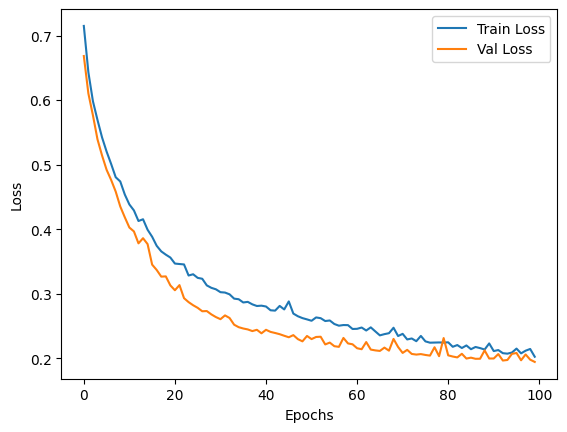

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
tp = 0  # True positives
fp = 0  # False positives
tn = 0  # True negatives
fn = 0  # False negatives
best_model_params.eval()
with torch.no_grad():
      for i, (inputs, labels) in enumerate(val_loader):
              outputs = best_model_params(inputs.float())
              loss = criterion(outputs, labels)
              epoch_val_loss += loss.item()
epoch_val_loss /= len(val_loader)
val_losses.append(epoch_val_loss)
predicted_labels = (outputs >= 0.5).float()

# Update confusion matrix
tp += torch.sum(predicted_labels * labels).item()
fp += torch.sum(predicted_labels * (1 - labels)).item()
tn += torch.sum((1 - predicted_labels) * (1 - labels)).item()
fn += torch.sum((1 - predicted_labels) * labels).item()

# Compute accuracy, precision, recall and F1 score
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

print(f'Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}')

Test Accuracy: 0.9231, Test Precision: 0.9333, Test Recall: 0.9333, Test F1: 0.9333
